# ML Homework3
0756021 張逸群

In [1]:
import numpy as np
import copy
import matplotlib.pyplot as plt
%matplotlib inline

## 1. Random Data Generator

### a. Univariate gaussian data generator

In [2]:
def sample_from_uni_normal(mean, var, size=1):
    # using Marsaglia polar method
    U, V = np.random.uniform(-1, 1, size), np.random.uniform(-1, 1, size)
    S = U*U + V*V
    
    # replace S >= 1
    while (S >= 1).any():
        replace_indices = (S >= 1)
        replace_size = replace_indices.sum()
        U[replace_indices], V[replace_indices] = np.random.uniform(-1, 1, replace_size), np.random.uniform(-1, 1, replace_size)
        S[replace_indices] = U[replace_indices]*U[replace_indices] + V[replace_indices]*V[replace_indices]
    
    X = U * np.sqrt( -2. * np.log(S) / S )
    return X * np.sqrt(var) + mean

In [3]:
def normal_generator(mean, var, cache_size=100):
    while True:
        data = sample_from_uni_normal(mean, var, size=cache_size)
        for d in data:
            yield d

#### Result

1.007002185695894 2.001563430313248


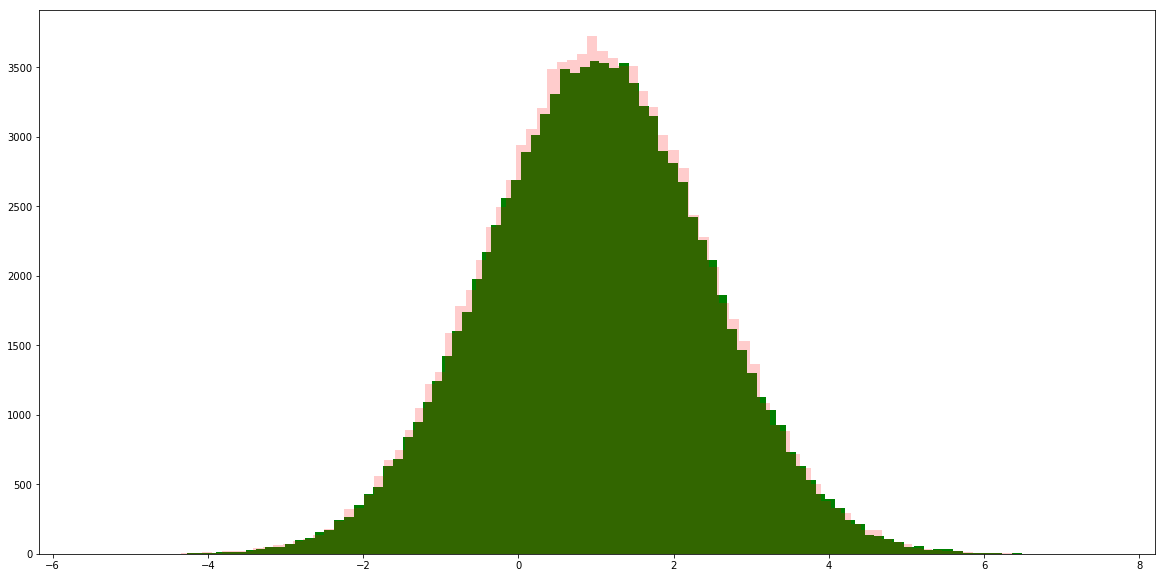

In [4]:
plt.figure(figsize=(20, 10))
X = sample_from_uni_normal(1, 2, 100000)
np_X = np.random.normal(1, np.sqrt(2), 100000) # numpy use std instead of var

_ = plt.hist(X, bins=100, color='green')
_ = plt.hist(np_X, bins=100, color='red', alpha=0.2)

print(X.mean(), X.var())

### b. Polynomial basis linear model data generator

In [5]:
def sample_from_poly_linear_model(weights, var, size=1, return_X=False):
    weights = np.array(weights)
    
    def phi(X):
        phi = np.ndarray((weights.shape[0], X.shape[0]))
        for i in range(weights.shape[0]):
            phi[i, :] = np.power(X, i)
        return phi
            
    X = np.random.uniform(-1., 1., size)
    e = sample_from_uni_normal(0, var, size)
    y = weights @ phi(X) + e
    if return_X:
        return X, y
    return y

In [6]:
def spl_generator(weights, var, return_X=False, cache_size=100):
    while True:
        data = sample_from_poly_linear_model(weights, var, size=cache_size, return_X=return_X)
        if return_X:
            X, y = data
            for xi, yi in zip(X, y):
                yield xi, yi
        else:
            for d in data:
                yield d

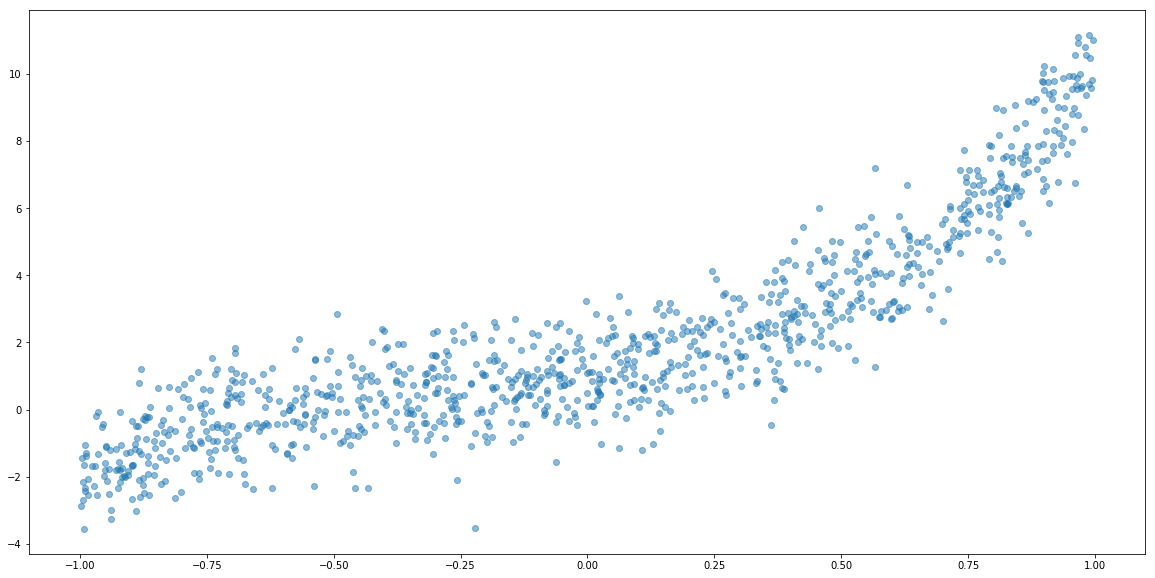

In [7]:
plt.figure(figsize=(20, 10))
X, y = sample_from_poly_linear_model([1, 2, 3, 4], 1, 1000, return_X=True)
plt.scatter(X, y, alpha=0.5)
plt.show()

## 2. Sequential Estimator

In [8]:
def sequential_estimator(data_generator, max_iter=None, max_delta=None, verbose=False):
    if max_iter is None and max_delta is None:
        raise('Either max_iter / max_delta must not be None!')
    
    # naive algorithm
    history = list()
    n_data = 0
    sum_data = 0.
    sum_square_data = 0.
    last_estimate = [0, 0]
    while True:
        if max_iter is not None and n_data >= max_iter:
            break
        
        data_new = next(data_generator)
        n_data += 1
        sum_data += data_new
        sum_square_data += data_new * data_new
        
        estimate_mean = sum_data / n_data
        estimate_var = (sum_square_data - sum_data*sum_data/n_data)/(n_data-1 + 1e-9)
        if max_delta is not None and\
            abs(last_estimate[0] - estimate_mean) < max_delta and\
            abs(last_estimate[1] - estimate_var) < max_delta:
            break
        last_estimate = [estimate_mean, estimate_var]
        history.append(last_estimate)
        
        if verbose:
            print('Add data point:', data_new)
            print('Mean =', estimate_mean, '\tVariance =', estimate_var)
    return np.array(history)

In [9]:
history = sequential_estimator(normal_generator(5., 2.), max_delta=0.001, verbose=False)

In [10]:
print('Final Estimate - mean:', history[-1, 0], 'variance:', history[-1, 1])

Final Estimate - mean: 5.022036469154777 variance: 2.0000413508364807


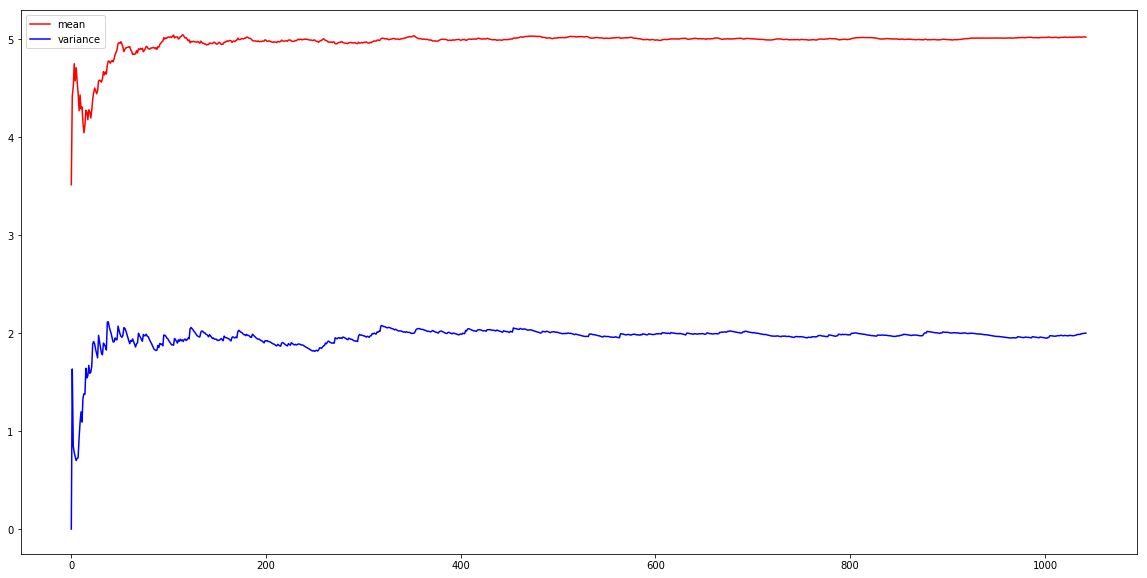

In [11]:
plt.figure(figsize=(20, 10))
plt.plot(history[:, 0], color='r', label='mean') # mean
plt.plot(history[:, 1], color='b', label='variance') # variance
plt.legend()

## 3. Baysian Linear Regression

In [12]:
def phi(X, basis_dim):
    X = np.array(X).reshape(-1)
    phi = np.ndarray((basis_dim, X.shape[0]))
    for i in range(basis_dim):
        phi[i, :] = np.power(X, i)
    return phi

def predict(weights, X):
    weights = np.array(weights).reshape(-1, 1)
    return (weights.T @ phi(X, weights.shape[0])).flatten()

def predictive_distribution(mu, precision, X, gt_var):
    means = mu.T @ phi(X, mu.shape[0])
    variances = list()
    for phi_xi in phi(X, mu.shape[0]).T:
        variances.append(1./gt_var + phi_xi @ np.linalg.inv(precision) @ phi_xi.T)
    return means.flatten(), np.array(variances)

def plot_predictive_distribution(gt_weights, gt_var, posteriors, data, ylim=None):
    def plot_posterior(ax, p, n_data, title=None):
        means, variances = predictive_distribution(p['mean'], p['precision'], X, gt_var)
        ax.plot(X, predict(p['mean'], X), color='black')
        ax.plot(X, means+variances, color='r')
        ax.plot(X, means-variances, color='r')
        ax.scatter(data['X'][:n_data], data['y'][:n_data])
        ax.set_title(title)
        
    X = np.arange(-2, 2, 0.05)
    
    f, axes = plt.subplots(2, 2, figsize=(20, 10))
    
    # plot ground truth
    gt_y = predict(gt_weights, X)
    axes[0, 0].plot(X, gt_y, color='black')
    axes[0, 0].plot(X, gt_y+gt_var, color='red')
    axes[0, 0].plot(X, gt_y-gt_var, color='red')
    axes[0, 0].set_title('Ground Truth')
    
    # plot predict result
    plot_posterior(axes[0, 1], posteriors['final'], -1, 'Predict result')
    plot_posterior(axes[1, 0], posteriors['10'], 10, 'After 10 incomes')
    plot_posterior(axes[1, 1], posteriors['50'], 50, 'After 50 incomes')
    
    # set all ylim
    for ax in axes.flatten():
        if ylim is not None:
            ax.set_ylim(*ylim)
        else:
            ax.set_ylim(-20, 25)

In [13]:
def baysian_linear_regression(data_generator, basis_dim, initial_a, prior_b, max_iter=None, max_delta=None, verbose=False):
    def verbose_function(posterior, X, y):
        print('Add data point ({:.5}, {:.5}):\n'.format(X, y.flatten()[0]))
        print('Postirior mean:')
        for i in range(basis_dim): print('\t{: .10f}'.format(posterior['mean'][i][0]))
        print()
        print('Posterior variance:')
        var = np.linalg.inv(posterior['precision'])
        for i in range(basis_dim):
            print(('\t{: .10f},'*basis_dim)[:-1].format(*var[i]))
        
        print()
        means, variances = predictive_distribution(posterior['mean'], posterior['precision'], X, initial_a)
        print('Predictive distribution ~ N({:.5f}, {:.5f})'.format(means[0], variances[0]))
        print('--------------------------------------------------')
    
    if max_iter is None and max_delta is None:
        raise('Either max_iter / max_delta must not be None!')
    
    prior = { 'mean': np.zeros((basis_dim, 1)), 
                'precision': prior_b * np.identity(basis_dim)}
    rtn_posteriors, rtn_data = dict(), {'X': list(), 'y': list()}
    last_prior = None
    n_iter = 0
    while True:
        if max_iter is not None and n_iter >= max_iter:
            break
            
        n_iter += 1
        
        # new data point
        X, y = next(data_generator)
        rtn_data['X'].append(X)
        rtn_data['y'].append(y)
        
        design_matrix = np.array([np.power(X, i) for i in range(basis_dim)]).reshape(1, basis_dim)
        y = np.array([y]).reshape(1, 1)
        
        last_prior = copy.deepcopy(prior)
        prior['precision'] = initial_a * design_matrix.T @ design_matrix + last_prior['precision']
        prior['mean'] = np.linalg.inv(prior['precision']) @ (initial_a * design_matrix.T @ y + last_prior['precision'] @ last_prior['mean'])
        if n_iter == 10:
            rtn_posteriors['10'] = copy.deepcopy(prior)
        elif n_iter == 50:
            rtn_posteriors['50'] = copy.deepcopy(prior)
        
        if max_delta is not None and\
            (np.absolute(prior['mean'] - last_prior['mean']) < max_delta).all():
            break
            
        if verbose:
            if n_iter < 5:
                verbose_function(prior, X, y)
    if verbose:
        print('\n...\n')
        verbose_function(prior, X, y)
    
    rtn_posteriors['final'] = copy.deepcopy(prior)
    rtn_data['X'] = np.array(rtn_data['X'])
    rtn_data['y'] = np.array(rtn_data['y'])
    return rtn_posteriors, rtn_data

Add data point (0.2969, 1.6792):

Postirior mean:
	 0.8008941991
	 0.2377850023
	 0.0705982231
	 0.0209605696

Posterior variance:
	 0.5230383189,	-0.1416096340,	-0.0420438145,	-0.0124827831
	-0.1416096340,	 0.9579561855,	-0.0124827831,	-0.0037061307
	-0.0420438145,	-0.0124827831,	 0.9962938693,	-0.0011003480
	-0.0124827831,	-0.0037061307,	-0.0011003480,	 0.9996733074

Predictive distribution ~ N(0.87826, 1.52304)
--------------------------------------------------
Add data point (0.48056, 2.4634):

Postirior mean:
	 1.2128604778
	 0.5305481844
	 0.2394310514
	 0.1104503114

Posterior variance:
	 0.4034895900,	-0.2265667485,	-0.0910375091,	-0.0384518622
	-0.2265667485,	 0.8975815469,	-0.0473000743,	-0.0221610156
	-0.0910375091,	-0.0473000743,	 0.9762151773,	-0.0117430469
	-0.0384518622,	-0.0221610156,	-0.0117430469,	 0.9940321510

Predictive distribution ~ N(1.53537, 1.39328)
--------------------------------------------------
Add data point (0.0075364, 0.74876):

Postirior mean:
	 1.078

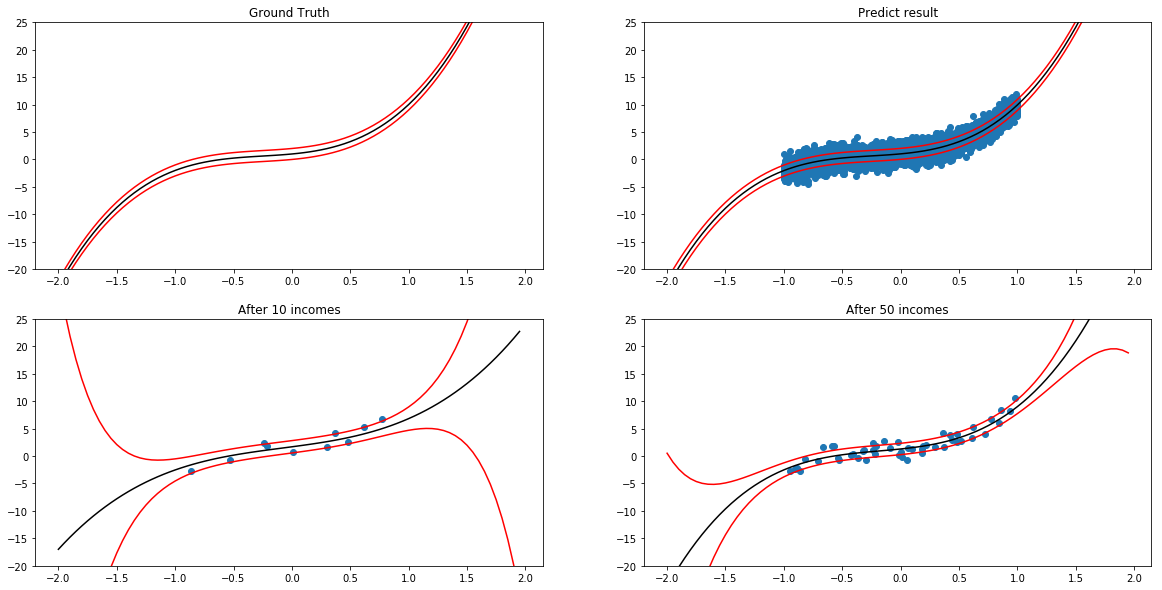

In [14]:
# parameters
b = 1
n = 4
a = 1
w = [1, 2, 3, 4]
dg = spl_generator(w, a, return_X=True, cache_size=100)

posteriors, data = baysian_linear_regression(data_generator=dg, basis_dim=n, initial_a=a, prior_b=b, max_delta=1e-6, verbose=True)
plot_predictive_distribution(w, a, posteriors, data)

Add data point (-0.26557, -0.60084):

Postirior mean:
	-0.0059444912
	 0.0015787034
	-0.0004192629
	 0.0001113454

Posterior variance:
	 0.0099010644,	 0.0000262747,	-0.0000069779,	 0.0000018531
	 0.0000262747,	 0.0099930221,	 0.0000018531,	-0.0000004921
	-0.0000069779,	 0.0000018531,	 0.0099995079,	 0.0000001307
	 0.0000018531,	-0.0000004921,	 0.0000001307,	 0.0099999653

Predictive distribution ~ N(-0.00640, 1.01064)
--------------------------------------------------
Add data point (0.46638, 3.9396):

Postirior mean:
	 0.0326678688
	 0.0198378498
	 0.0080298681
	 0.0040695862

Posterior variance:
	 0.0098040464,	-0.0000196035,	-0.0000282073,	-0.0000080924
	-0.0000196035,	 0.0099713271,	-0.0000081859,	-0.0000051952
	-0.0000282073,	-0.0000081859,	 0.0099948624,	-0.0000020456
	-0.0000080924,	-0.0000051952,	-0.0000020456,	 0.0099989457

Predictive distribution ~ N(0.04408, 1.01251)
--------------------------------------------------
Add data point (0.5674, 4.3142):

Postirior mean:
	 0.07

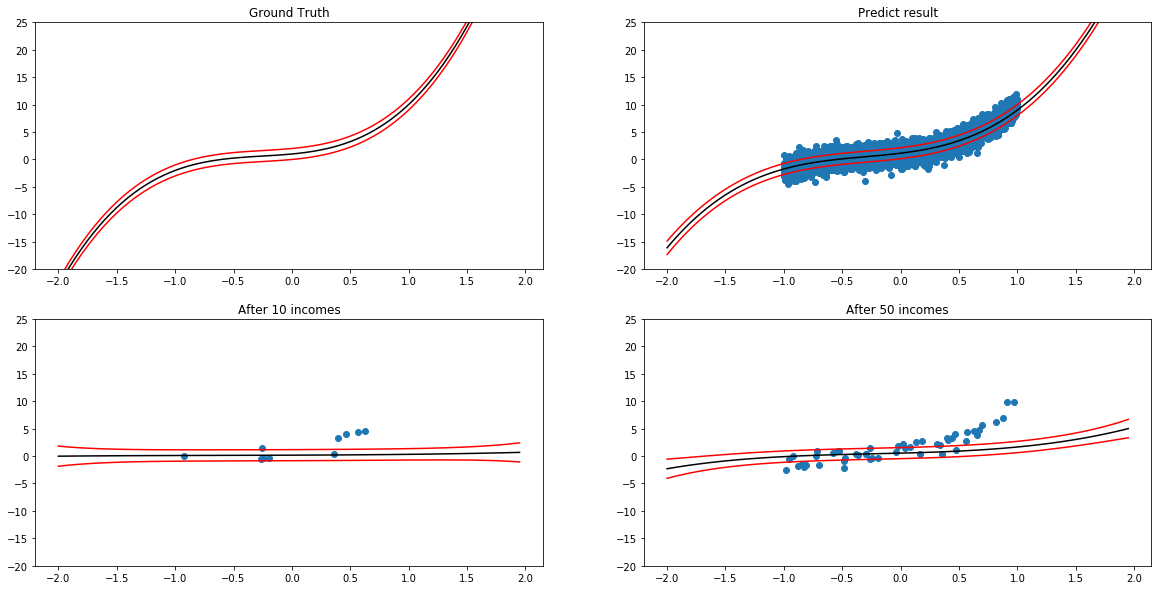

In [15]:
# parameters
b = 100
n = 4
a = 1
w = [1, 2, 3, 4]
dg = spl_generator(w, a, return_X=True, cache_size=100)

posteriors, data = baysian_linear_regression(data_generator=dg, basis_dim=n, initial_a=a, prior_b=b, max_delta=1e-6, verbose=True)
plot_predictive_distribution(w, a, posteriors, data)

Add data point (-0.61123, 3.1147):

Postirior mean:
	 1.6867811444
	-1.0310076714
	 0.6301806384

Posterior variance:
	 0.4584376536,	 0.3310180076,	-0.2023274367
	 0.3310180076,	 0.7976725633,	 0.1236681712
	-0.2023274367,	 0.1236681712,	 0.9244105653

Predictive distribution ~ N(2.55240, 0.60649)
--------------------------------------------------
Add data point (0.17448, 0.34862):

Postirior mean:
	 1.0350176352
	-1.6366705300
	 0.8251980508

Posterior variance:
	 0.1761177374,	 0.0686671932,	-0.1178530856
	 0.0686671932,	 0.5538783926,	 0.2021674677
	-0.1178530856,	 0.2021674677,	 0.8991345731

Predictive distribution ~ N(0.77458, 0.54608)
--------------------------------------------------
Add data point (-0.64186, -0.22434):

Postirior mean:
	 0.6651131943
	-0.7347893678
	 0.2810410584

Posterior variance:
	 0.1644632185,	 0.0970826159,	-0.1349977512
	 0.0970826159,	 0.4845974334,	 0.2439686717
	-0.1349977512,	 0.2439686717,	 0.8739134926

Predictive distribution ~ N(1.25253, 0.480

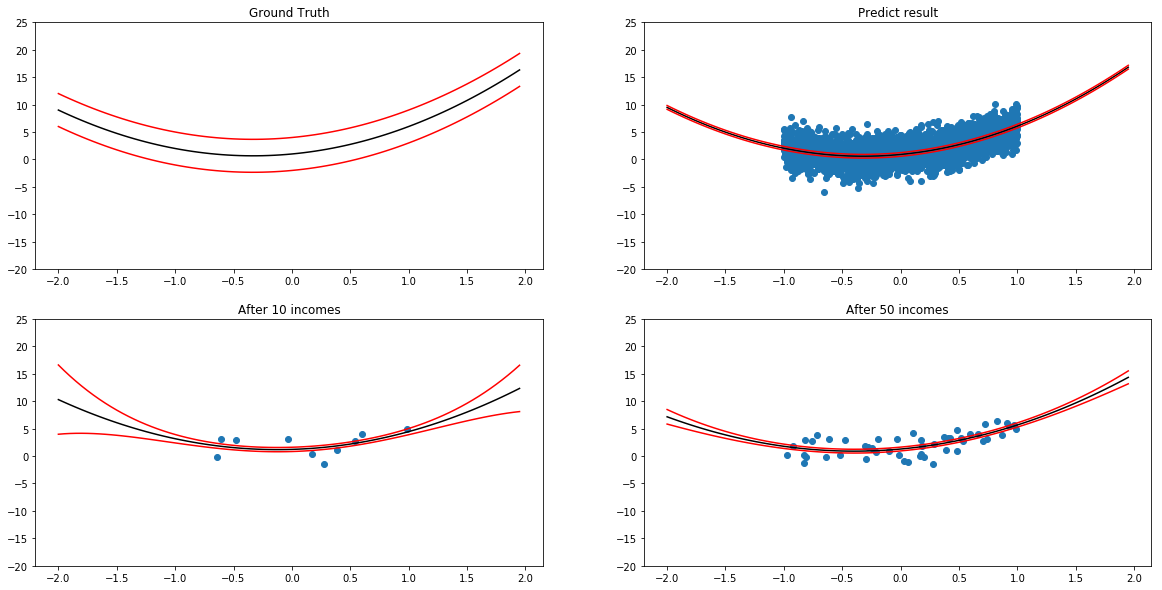

In [16]:
# parameters
b = 1
n = 3
a = 3
w = [1, 2, 3]
dg = spl_generator(w, a, return_X=True, cache_size=100)

posteriors, data = baysian_linear_regression(data_generator=dg, basis_dim=n, initial_a=a, prior_b=b, max_delta=1e-6, verbose=True)
plot_predictive_distribution(w, a, posteriors, data)